# 毕业项目：为 Arvato Financial Services 金融服务公司实现一个顾客分类报告

该项目要求你分析德国的一家邮购公司的顾客的人口统计数据，将它和一般的人口统计数据进行比较。你将使用非监督学习技术来实现顾客分类，识别出哪些人群是这家公司的基础核心用户。之后，你将把所学的知识应用到第三个数据集上，该数据集是该公司的一场邮购活动的营销对象的人口统计数据。用你搭建的模型预测哪些人更可能成为该公司的顾客。你要使用的数据由我们的合作伙伴 Bertelsmann Arvato Analytics 公司提供。这是真实场景下的数据科学任务。

如果你完成了这个纳米学位的第一学期，做过其中的非监督学习项目，那么你应该对这个项目的第一部分很熟悉了。两个数据集版本不同。这个项目中用到的数据集会包括更多的特征，而且没有预先清洗过。你也可以自由选取分析数据的方法，而不用按照既定的步骤。如果你选择完成的是这个项目，请仔细记录你的步骤和决策，因为你主要交付的成果就是一篇博客文章报告你的发现。

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
conn = sqlite3.connect('arvato_project.db')
# magic word for producing visualizations in notebook
%matplotlib inline

## 第 0 部分：了解数据

项目数据中包括四个数据文件

- `Udacity_AZDIAS_052018.csv`: 德国的一般人口统计数据；891211 人（行）x 366 个特征（列）
- `Udacity_CUSTOMERS_052018.csv`: 邮购公司顾客的人口统计数据；191652 人（行）x 369 个特征（列）
- `Udacity_MAILOUT_052018_TRAIN.csv`: 营销活动的对象的人口统计数据；42982 人（行）x 367 个特征（列）
- `Udacity_MAILOUT_052018_TEST.csv`: 营销活动的对象的人口统计数据；42833 人（行）x 366个特征（列）

人口统计数据的每一行表示是一个单独的人，也包括一些非个人特征，比如他的家庭信息、住房信息以及周边环境信息。使用前两个数据文件中的信息来发现顾客（"CUSTOMERS"）和一般人（"AZDIAS"）在何种程度上相同和不同，然后根据你的分析对其余两个数据文件（"MAILOUT"）进行预测，预测更可能成为该邮购公司的客户。

"CUSTOMERS" 文件包括三个额外的列（'CUSTOMER_GROUP'、’'ONLINE_PURCHASE' 和 'PRODUCT_GROUP'），提供了文件中顾客的更多维度的信息。原始的 "MAILOUT" 包括一个额外的列 "RESPONSE"，表示每个收到邮件的人是否成为了公司的顾客。对于 "TRAIN" 子数据集，该列被保留，但是在 "TEST" 子数据集中该列被删除了，它和你最后要在 Kaggle 比赛上预测的数据集中保留的列是对应的。

三个数据文件中其他的所有列都是相同的。要获得关于文件中列的更多信息，你可以参考 Workspace 中的两个 Excel 电子表格。[其一](./DIAS Information Levels - Attributes 2017.xlsx) 是一个所有属性和描述的列表，按照信息的类别进行排列。[其二](./DIAS Attributes - Values 2017.xlsx) 是一个详细的每个特征的数据值对应关系，按照字母顺序进行排列。

在下面的单元格中，我们提供了一些简单的代码，用于加载进前两个数据集。注意，这个项目中所有的 `.csv` 数据文件都是分号(`;`) 分割的，所以 [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) 中需要加入额外的参数以正确地读取数据。而且，考虑数据集的大小，加载整个数据集可能会花费一些时间。

你会注意到在数据加载的时候，会弹出一个警告（warning）信息。在你开始建模和分析之前，你需要先清洗一下数据。浏览一下数据集的结构，查看电子表格中信息了解数据的取值。决定一下要挑选哪些特征，要舍弃哪些特征，以及是否有些数据格式需要修订。我们建议创建一个做预处理的函数，因为你需要在使用数据训练模型前清洗所有数据集。

In [2]:
# 导入人口统计数和顾客数据，以及训练集和测试集数据
azdias = pd.read_csv('./arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
train = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#查看数据集的结构
print(azdias.shape)
print(customers.shape)
print(train.shape)
print(test.shape)

(891221, 366)
(191652, 369)
(42962, 367)
(42833, 366)


## 第1部分：顾客分类报告

项目报告的主体部分应该就是这部分。在这个部分，你应该使用非监督学习技术来刻画公司已有顾客和德国一般人群的人口统计数据的关系。这部分做完后，你应该能够描述一般人群中的哪一类人更可能是邮购公司的主要核心顾客，哪些人则很可能不是。

In [ ]:
#变量筛选第一步，人口数据抽样191652，和customer放在同一个表格内，导出成excel进行单变量的结构比较
azdias_sample = azdias.sample(n=191652)
customers_sample = customers
a =50
j=0
#初始化一个DataFrame，记为AGER_TYP
STAT2_1 = pd.DataFrame(azdias_sample.groupby(['AGER_TYP']).count()['LNR'])
STAT2_2 = pd.DataFrame(customers.groupby(['AGER_TYP']).count()['LNR'])
STAT_1_NEW= pd.concat([STAT2_1,STAT2_2],axis=1)
STAT_1_NEW['name'] = 'AGER_TYP' 
#将其他分析结果也匹配上去
for i in azdias_sample.columns:    
    if i!='LNR' and i!='AGER_TYP':
        STAT1_1 = pd.DataFrame(azdias_sample.groupby([i]).count()['LNR'])
        STAT1_2 = pd.DataFrame(customers_sample.groupby([i]).count()['LNR'])
        STAT_1_NEW_PRE = pd.concat([STAT1_1,STAT1_2],axis=1)
        STAT_1_NEW_PRE['name'] = i
        STAT_1_NEW = STAT_1_NEW[STAT_1_NEW['name']!=i]
        STAT_1_NEW = pd.concat([STAT_1_NEW,STAT_1_NEW_PRE],axis=0)
        j = j+1
        print(i)
    if j % a ==0:
        STAT_1_NEW.to_csv('STAT_NEW1_%s.csv' %str(j/a))
    if j ==364:
        STAT_1_NEW.to_csv('STAT_NEW1_8.csv')  ##到最后不能整除的时候会不能导出，漏掉一部分

In [ ]:
#变量筛选第二步，根据维度的属性分类，计算相关性，进而筛选变量
PLZ8_X = pd.read_csv('./submit/PLZ8.txt')
customers[PLZ8_X['NAME'].values].corr(method='kendall').to_csv('PLZ8.csv')
microcell_X = pd.read_csv('./submit/microcell.txt')
customers[microcell_X['name'].values].corr(method='kendall').to_csv('microcell.csv')
PERSON_X = pd.read_csv('./submit/PERSON.txt')
customers[PERSON_X['NAME'].values].corr(method='kendall').to_csv('PERSON.csv')

In [5]:
#分类变量从文本中导入
object_columns = pd.read_csv('./submit/object.txt', sep=';')

In [ ]:
a =10
j=0
#重要变量的单变量分析，做报告使用：初始化
STAT2_1 = pd.DataFrame(azdias.groupby(['AGER_TYP']).count()['LNR'])
STAT2_2 = pd.DataFrame(customers.groupby(['AGER_TYP']).count()['LNR'])
STAT_1_NEW= pd.concat([STAT2_1,STAT2_2],axis=1)
STAT_1_NEW['name'] = 'AGER_TYP' 
for i in object_columns['NAME'].tolist():    
    if i!='LNR' and i!='AGER_TYP':
        STAT1_1 = pd.DataFrame(azdias.groupby([i]).count()['LNR'])
        STAT1_2 = pd.DataFrame(customers.groupby([i]).count()['LNR'])
        STAT_1_NEW_PRE = pd.concat([STAT1_1,STAT1_2],axis=1)
        STAT_1_NEW_PRE['name'] = i
        STAT_1_NEW = STAT_1_NEW[STAT_1_NEW['name']!=i]
        STAT_1_NEW = pd.concat([STAT_1_NEW,STAT_1_NEW_PRE],axis=0)
        j = j+1
        print(i)
    if j % a ==0:
        STAT_1_NEW.to_csv('STAT_NEW2_%s.csv' %str(j/a))
    if j ==72:
        STAT_1_NEW.to_csv('STAT_NEW2_8.csv')  ##到最后不能整除的时候会不能导出，漏掉一部分

## 第2部分：监督学习模型

你现在应该已经发现哪部分人更可能成为邮购公司的顾客了，是时候搭建一个预测模型了。"MAILOUT"数据文件的的每一行表示一个邮购活动的潜在顾客。理想情况下我们应该能够使用每个人的人口统计数据来决定是否该把他作为该活动的营销对象。

"MAILOUT" 数据被分成了两个大致相等的部分，每部分大概有 43 000 行数据。在这部分，你可以用"TRAIN"部分来检验你的模型，该数据集包括一列"RESPONSE"，该列表示该对象是否参加了该公司的邮购活动。在下一部分，你需要在"TEST"数据集上做出预测，该数据集中"RESPONSE" 列也被保留了。

In [6]:
# 数据预处理，负样本抽样，正负样本比例1：10
RESPONSE = train[train['RESPONSE']==1]
NO_RESPONSE = train[train['RESPONSE']==0].sample(5320)
#模型训练数据集和测试集准备
data = pd.concat([RESPONSE,NO_RESPONSE],axis=0)
data['DATA_TYPE'] ='train'
test['DATA_TYPE'] ='test'
data = pd.concat([data,test],axis=0)
#离散的feature处理one-hot编码
data_new = pd.DataFrame(data['RESPONSE'])
for i in object_columns['NAME'].tolist():
    data_new[i]=data[i].astype('object')
    data_cat = pd.get_dummies(data_new[i], prefix=i)
    data_new = data_new.drop([i],axis=1)
    data_new = pd.concat([data_new, data_cat], axis=1)
# data_new = pd.concat([data_new,data['RESPONSE']],axis=1)
#EINGEFUEGT_AM日期变量的拆分和分段，以及one-hot处理
data_new['EINGEFUEGT_AM']=data['EINGEFUEGT_AM'].str.split('-').str.get(0).fillna(-1)
data_new['EINGEFUEGT_AM'] = data_new['EINGEFUEGT_AM'].astype('int')
bins = [-1,1914,1919,1924,1929,1934,1939,1944,1949,1965,1974,2017]
level = ['1914以下',
'1915-1919',
'1920-1924',
'1925-1929',
'1930-1934',
'1935-1939',
'1940-1944',
'1945-1949',
'1950-1965',
'1965-1974',
'1975以上']
data_new['GEBURTSJAHR_NEW'] = pd.cut(data_new['EINGEFUEGT_AM'],bins=bins,labels =level)
data_cat = pd.get_dummies(data_new['GEBURTSJAHR_NEW'], prefix='GEBURTSJAHR_NEW')
data_new = data_new.drop(['GEBURTSJAHR_NEW'],axis=1)
data_new = pd.concat([data_new, data_cat], axis=1)
#序号以及类型补充
data_new['DATA_TYPE']=data['DATA_TYPE']
data_new['RESPONSE']=data['RESPONSE']
data_new['LNR']=data['LNR']
#数值型变量的补充
number_data_column = pd.read_csv('./submit/scale.txt', sep=';')
for i in number_data_column['NAME'].tolist():
    data_new = pd.concat([data_new, data[i]], axis=1)
#空值填充
data_new = data_new.fillna(-1)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
#模型数据拆分训练集和测试集
from sklearn.model_selection import train_test_split,GridSearchCV
data_new_train = data_new[data_new['DATA_TYPE']=='train']
X_train, X_test, y_train, y_test = train_test_split(data_new_train.drop(['RESPONSE','LNR','DATA_TYPE'],axis=1), data_new_train['RESPONSE'], test_size=0.3, random_state=0)
X = data_new_train.drop(['RESPONSE'],axis=1)
y = data_new_train['RESPONSE']

In [324]:
#模型1：回归模型
from sklearn.linear_model.logistic import LogisticRegression
clf1 = LogisticRegression()
cv_params ={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
clf = GridSearchCV(clf1,cv_params, verbose=2,scoring = 'roc_auc', refit=True, cv=3, n_jobs=-1)
# scores = cross_val_score(clf, X,y, cv=5)
# printscores.mean()
clf.fit(X_train,y_train)
print("参数的最佳取值：:", clf.best_params_)
print("最佳模型得分:", clf.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   42.2s finished


参数的最佳取值：: {'solver': 'lbfgs'}
最佳模型得分: 0.7264102328174002


In [36]:
#模型2：xgboost模型调参
from xgboost.sklearn import XGBClassifier
clf1 = XGBClassifier()
cv_params ={'learning_rate': [0.12,0.15]}
clf = GridSearchCV(clf1, cv_params, verbose=2,scoring = 'roc_auc', refit=True, cv=5, n_jobs=-1)
# scores = cross_val_score(clf, X,y, cv=5)
# printscores.mean()
clf.fit(X_train,y_train)
print("参数的最佳取值：:", clf.best_params_)
print("最佳模型得分:", clf.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


参数的最佳取值：: {'learning_rate': 0.12}
最佳模型得分: 0.7576343208662722


In [39]:
#模型2：xgboost模型调参
from xgboost.sklearn import XGBClassifier
clf1 = XGBClassifier(learning_rate=0.09,scale_pos_weight=10,n_estimators=15)
cv_params ={'max_depth': [1]}
clf = GridSearchCV(clf1, cv_params, verbose=2,scoring = 'roc_auc', refit=True, cv=5, n_jobs=-1)
# scores = cross_val_score(clf, X,y, cv=5)
# printscores.mean()
clf.fit(X_train,y_train)
print("参数的最佳取值：:", clf.best_params_)
print("最佳模型得分:", clf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.7461147737961809


In [49]:
#模型跑预测集
from sklearn.model_selection import train_test_split,GridSearchCV
##模型包导入
from sklearn.linear_model import LogisticRegression 
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_curve,auc
# clf = LogisticRegression(random_state=0,penalty='l2',solver='newton-cg',C=3)
# n_estimators=18,max_depth=3,scale_pos_weight=10,random_state=42,learning_rate=0.09
clf = XGBClassifier(n_estimators=15,scale_pos_weight=10,max_depth=2,random_state=42,learning_rate=0.08)
# clf =LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train, eval_metric='auc')
# clf.fit(X_train, y_train)
y_train_pred_proba = clf.predict_proba(X_train)
y_test_pred_proba = clf.predict_proba(X_test)
np_con=[]
for i in np.arange(0,1,0.1):    
    y_pred_pre=[]
    for j in range(0,len(y_test_pred_proba[:,1])):
        if y_test_pred_proba[:,1][j]>i:
            y_pred_pre.append(1)
        else:
            y_pred_pre.append(0)   
    y_train_pred_pre=[]
    for h in range(0,len(y_train_pred_proba[:,1])):
        if y_train_pred_proba[:,1][h]>i:
            y_train_pred_pre.append(1)
        else:
            y_train_pred_pre.append(0)
    F1 = f1_score(y_test, y_pred_pre)
    confusion_matrix1 = confusion_matrix(y_test, y_pred_pre)
    fpr,tpr,threshold = roc_curve(np.array(y_test),np.array(y_pred_pre)) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    fpr_train,tpr_train,threshold_train = roc_curve(np.array(y_train),np.array(y_train_pred_pre)) ###计算真正率和假正率
    roc_auc_train = auc(fpr_train,tpr_train) ###计算auc的值
    np_con_pre=[]
    np_con_pre.append(i)
    np_con_pre.append(F1)
    np_con_pre.append(confusion_matrix1[0][0])
    np_con_pre.append(confusion_matrix1[0][1])
    np_con_pre.append(confusion_matrix1[1][0])
    np_con_pre.append(confusion_matrix1[1][1])
    np_con_pre.append(roc_auc)
    np_con_pre.append(roc_auc_train)    
    np_con.append(np_con_pre)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


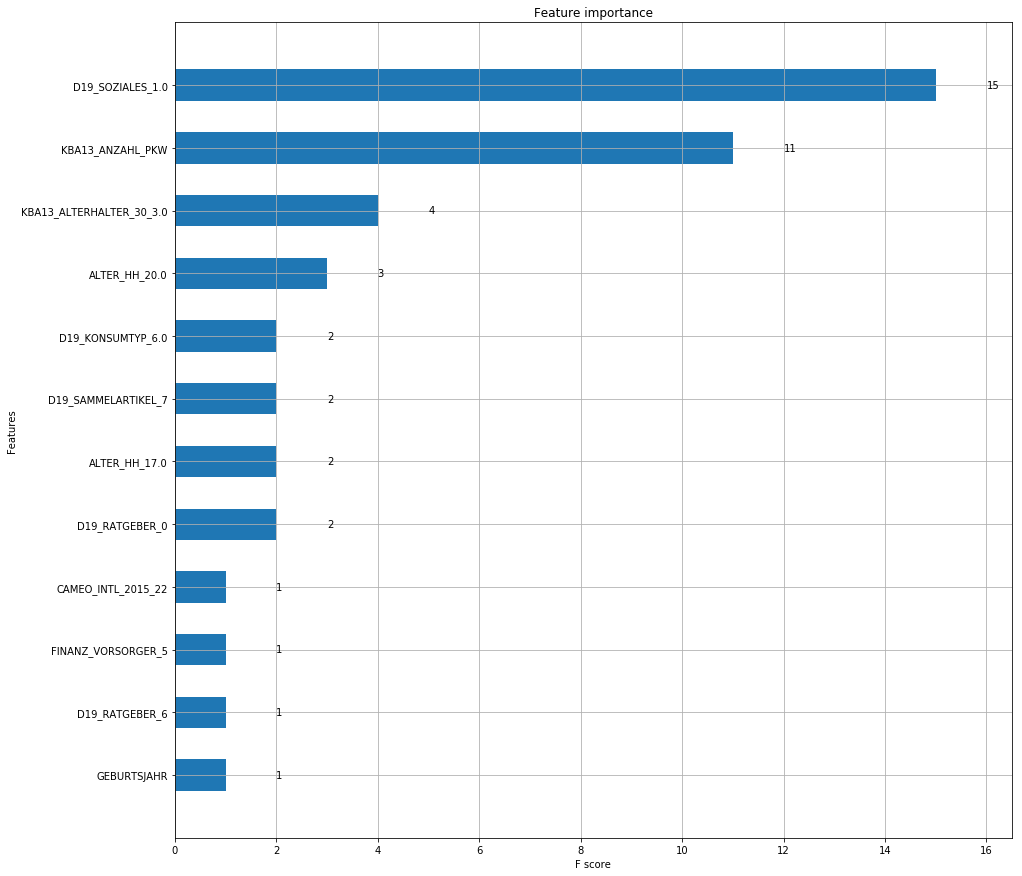

In [55]:
### plot feature importance重要变量的输出
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(clf,
                 height=0.5,
                 ax=ax,
                 max_num_features=64)
plt.show()

In [50]:
#评估报告
report = pd.DataFrame(np_con,columns=['i','prob','TN','FP','FN','TP','roc','roc_train'])
report['Precision']= report['TP']/(report['TP']+report['FP'])
report['Recall']= report['TP']/(report['TP']+report['FN'])
report['Sensitivity']= report['FP']/(report['FP']+report['FN'])
report['1-Specificity']= report['FP']/(report['FP']+report['TN'])
report

,i,prob,TN,FP,FN,TP,roc,roc_train,Precision,Recall,Sensitivity,1-Specificity
0,0.0,0.163180,0,1600,0,156,0.500000,0.500000,0.088838,1.000000,1.000000,1.000000
1,0.1,0.163180,0,1600,0,156,0.500000,0.500000,0.088838,1.000000,1.000000,1.000000
2,0.2,0.163180,0,1600,0,156,0.500000,0.500000,0.088838,1.000000,1.000000,1.000000
3,0.3,0.269347,895,705,22,134,0.709175,0.722149,0.159714,0.858974,0.969739,0.440625
4,0.4,0.270707,900,700,22,134,0.710737,0.723493,0.160671,0.858974,0.969529,0.437500
5,0.5,0.332344,1194,406,44,112,0.732099,0.726361,0.216216,0.717949,0.902222,0.253750
6,0.6,0.334347,1208,392,46,110,0.730064,0.729198,0.219124,0.705128,0.894977,0.245000
7,0.7,0.000000,1600,0,156,0,0.500000,0.500000,NaN,0.000000,0.000000,0.000000
8,0.8,0.000000,1600,0,156,0,0.500000,0.500000,NaN,0.000000,0.000000,0.000000
9,0.9,0.000000,1600,0,156,0,0.500000,0.500000,NaN,0.000000,0.000000,0.000000


## Part 3:Kaggle比赛

你已经搭建了一个用于预测人们有多大程度上会回应邮购活动的模型，是时候到Kaggle上检验一下这个模型了。如果你点击这个 [链接](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140)，你会进入到比赛界面（如果你已经有一个Kaggle账户的话）如果你表现突出的话，你将有机会收到Arvato或Bertelsmann的人力资源管理的经理的面试邀约！

你比赛用提交的文件格式为CSV，该文件含2列。第一列是"LNR"，是"TEST"部分每个顾客的ID。第二列是"RESPONSE"表示此人有多大程度上会参加该活动，可以是某种度量，不一定是概率。你应该在第2部分已经发现了，该数据集存在一个巨大的输出类不平衡的问题，也就是说大部分人都不会参加该邮购活动。因此，预测目标人群的分类并使用准确率来衡量不是一个合适的性能评估方法。相反地，该项竞赛使用AUC衡量模型的性能。"RESPONSE"列的绝对值并不重要：仅仅表示高的取值可能吸引到更多的实际参与者，即ROC曲线的前端曲线比较平缓。

In [218]:
#测试集准备
test_import_pre = data_new[data_new['DATA_TYPE']=='test']
test_import = test_import_pre.drop(['RESPONSE','LNR','DATA_TYPE'],axis=1)
test_import.shape

(42833, 2807)

In [223]:
#预测集导出
test_pred = pd.DataFrame(clf.predict_proba(test_import)[:,1],columns = ['test_pred_proba'])
pd.concat([test_pred,test_import_pre['LNR']],axis=1).to_csv('bbb.csv')